In [8]:
import csv
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, regularizers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, Concatenate
from keras.optimizers import Adam

In [9]:
import sys
from data import ProcessData


In [10]:
# Training
en_training_path = keras.utils.get_file(
    "en_ewt-ud-train.conllu",
    "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu")
en_training_txt = open(en_training_path,encoding="utf8")
en_training_data=en_training_txt.read()

en_training_lines = en_training_data.split("\n")

# Validation
en_validation_path = keras.utils.get_file(
    "en_ewt-ud-dev.conllu",
    "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu")
en_validation_txt = open(en_validation_path,encoding="utf8")
en_validation_data = en_validation_txt.read()

en_validation_lines = en_validation_data.split("\n")


# Test
en_test_path = keras.utils.get_file(
    "en_ewt-ud-test.conllu",
    "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-test.conllu")
en_test_txt = open(en_test_path,encoding="utf8")
en_test_data = en_test_txt.read()

en_test_lines = en_test_data.split("\n")

In [11]:
def preprocess_data(text_lines):
  inputs = []
  aux_inputs = [['0', 'ROOT', 'ROOT', '', '']]
  d=[]
  # we obtain the inputs and the targets -- words and its tags
  for i in text_lines:
    if i.startswith('#'):  # we are not interested in this lines of the data
      continue
    if len(i) == 0:
      inputs.append(aux_inputs)
      aux_inputs = [['0', 'ROOT', 'ROOT', '', '']]
      continue
    aux0 = i.split("\t")[0]
    if ("-" in aux0) or ("." in aux0):  # we ignore the lines with the contractions of the language
      continue
    aux_ = i.split("\t")
    d.append(aux_[0]) # word id
    d.append(aux_[1]) # word
    d.append(aux_[3]) # UPOS
    d.append(aux_[6]) # head id
    d.append(aux_[7]) # dependency label
    aux_inputs.append(d)
    d=[]
  return inputs

In [12]:
inputs=preprocess_data(en_training_lines)
validation_inputs=preprocess_data(en_validation_lines)

In [13]:
# Eliminate the non-projective trees
def preprocess_tree(text_lines):
  tree_inputs = []
  aux_inputs = []
  d=[]
  # we obtain the inputs and the targets -- words and its tags
  for i in text_lines:
    if i.startswith('#'):  # we are not interested in this lines of the data
      continue
    if len(i) == 0:
      tree_inputs.append(aux_inputs)
      aux_inputs = []
      continue
    aux0 = i.split("\t")[0]
    if ("-" in aux0) or ("." in aux0):  # we ignore the lines with the contractions of the language
      continue
    aux_ = i.split("\t")
    d.append(aux_[0])
    d.append(aux_[6])
    aux_inputs.append(d)
    d=[]
  return tree_inputs

In [14]:
tree_inputs=preprocess_tree(en_training_lines)
validation_tree_inputs=preprocess_tree(en_validation_lines)

In [15]:
def is_projective(arcs: list):
    """
    Determines if a dependency tree has crossing arcs or not.
    Parameters:
    arcs (list): A list of tuples of the form (headid, dependentid, coding
    the arcs of the sentence, e.g, [(0,3), (1,4), …]
    Returns:
    A boolean: True if the tree is projective, False otherwise
    """
    for (i,j) in arcs:
        for (k,l) in arcs:
            if (i,j) != (k,l) and min(i,j) < min(k,l) < max(i,j) < max(k,l):
                return False
    return True

In [16]:
tree_inputs[0]

[['1', '0'],
 ['2', '1'],
 ['3', '1'],
 ['4', '1'],
 ['5', '6'],
 ['6', '7'],
 ['7', '1'],
 ['8', '7'],
 ['9', '8'],
 ['10', '8'],
 ['11', '8'],
 ['12', '8'],
 ['13', '8'],
 ['14', '15'],
 ['15', '8'],
 ['16', '18'],
 ['17', '18'],
 ['18', '15'],
 ['19', '21'],
 ['20', '21'],
 ['21', '18'],
 ['22', '23'],
 ['23', '21'],
 ['24', '21'],
 ['25', '28'],
 ['26', '28'],
 ['27', '28'],
 ['28', '21'],
 ['29', '1']]

In [17]:
# Boolean list that says if a tree if projective or not
tree=[]
inputs2=[]
for idx, sentence in enumerate(tree_inputs):
    if is_projective(sentence):
        tree.append(sentence)
        inputs2.append(inputs[idx])
        
        
#############################################

validation_tree=[]
validation_inputs2=[]
for idx, sentence in enumerate(validation_tree_inputs):
    if is_projective(sentence):
        validation_tree.append(sentence)
        validation_inputs2.append(validation_inputs[idx])

In [18]:
inputs_=[]
aux= []
for sentence in inputs2:
  d=[]
  for word in sentence:
    d.append(word[1])
    d.append(word[2])
    aux.append(d)
    d=[]
  inputs_.append(aux)
  aux=[]
  
###############################################
  
validation_inputs_=[]
aux= []
for sentence in validation_inputs2:
  d=[]
  for word in sentence:
    d.append(word[1])
    d.append(word[2])
    aux.append(d)
    d=[]
  validation_inputs_.append(aux)
  aux=[]
  

In [20]:
def get_tokenizer_inputs(inputs):
  tokenizer_inputs = []
  encoderUPOS_inputs = []
  encoderDEPREL_inputs = []
  for i in inputs:
    for y in i:
      tokenizer_inputs.append(y[1])
      encoderUPOS_inputs.append(y[2])
      encoderDEPREL_inputs.append(y[4])
      
  return tokenizer_inputs, encoderUPOS_inputs, encoderDEPREL_inputs

In [21]:
inputs2[0][1]

['1', '[', 'PUNCT', '10', 'punct']

In [22]:
def preprocess_oracle(text_lines):
  oracle_inputs = []
  aux_inputs = [['0', '', '']]
  d=[]
  # we obtain the inputs and the targets -- words and its tags
  for i in text_lines:
    if i.startswith('#'):  # we are not interested in this lines of the data
      continue
    if len(i) == 0:
      oracle_inputs.append(aux_inputs)
      aux_inputs = [['0', '', '']]
      continue
    aux0 = i.split("\t")[0]
    if ("-" in aux0) or ("." in aux0):  # we ignore the lines with the contractions of the language
      continue
    aux_ = i.split("\t")
    d.append(aux_[0])
    d.append(aux_[6])
    d.append(aux_[7])
    aux_inputs.append(d)
    d=[]
  return oracle_inputs

In [23]:
oracle_inputs=preprocess_oracle(en_training_lines)
validation_oracle_inputs=preprocess_oracle(en_validation_lines)

In [24]:
oracle_=[]
for idx, sentence in enumerate(tree_inputs):
    if is_projective(sentence):
        oracle_.append(oracle_inputs[idx]) 
        
#############################################

validation_oracle_=[]
for idx, sentence in enumerate(validation_tree_inputs):
    if is_projective(sentence):
        validation_oracle_.append(validation_oracle_inputs[idx]) 

In [25]:
"""
Definitions

-	σ: stack of tokens
-	β: buffer of tokens
-	A: dependency arcs (i,l,j)
	-		i: head
	-		l: dependency type of j
	-		j: dependent

-	σ|i: stack with top i and tail σ
-	j|β: buffer with head j and tail β

"""

# *!* Comprobar orden de i,j


###################################################################
#			CREATE INITIAL STATE
###################################################################

def create_initial_state(sentence):
  # [σ, β, A] = [[ROOT], [w1, w2, ...]., {}]

  alpha = [0]
  betha = list(range(1,len(sentence)))
  A = []
  return [alpha, betha, A]

###################################################################
#			CHECK IF TRANSITION IS VALID
###################################################################

def LA_is_valid(state):
	# σ|i
	i = state[0][-1]
	#j|β
	j = state[1][0]
	# ¬[i = 0]
	if i == 0:
		return False
	# ¬∃k∃l [(k, l , i) ∈ A]
	for s in state[2]:
		if s[2] == i:
			return False
	return True
	
def RA_is_valid(state):
	# σ|i
	i = state[0][-1]
	#j|β
	j = state[1][0]
	# ¬∃k∃l [(k, l , j) ∈ A]
	for s in state[2]:
		if s[2] == j:
			return False
	return True

def REDUCE_is_valid(state):
	# σ|i
	i = state[0][-1]
	# ∃k∃l[(k, l, i) ∈ A]
	for s in state[2]:
		if s[2] == i:
			return True
	return False

###################################################################
#			PERFORM TRANSITION IS VALID
###################################################################

def apply_LA(state,sentence):
	# (σ|i, j|β, A) ⇒ (σ, j|β, A∪{(j, l, i)})
	# A element ()
	i=state[0][-1]
	j=state[1][0]
	# Add a dependency arc (j, l, i) to A, where i is the node on top of the 
	# stack σ and j is the first node in the buffer β
	state[2].append((state[1][0], sentence[i][2], state[0][-1]))
	# pop the stack σ
	state[0].pop(-1)
	return state


def apply_RA(state,sentence):
	# (σ|i, j|β, A) ⇒ (σ|i|j,β, A∪{(i, l, j)})
	# *!* l ????
	i=state[0][-1]
	j = state[1][0]
	# Add a dependency arc (i, l, j) to A, where i is the node on top of the 
	# stack σ and j is the first node in the buffer β
	state[2].append((state[0][-1], sentence[j][2], state[1][0]))
	# remove the first node j in the buffer β and push it on top of the stack σ
	state[0].append(j)
	state[1].pop(0)
	return state

def apply_REDUCE(state):
	# (σ|i,β, A) ⇒ (σ,β, A)
	# pops the stack 
	state[0].pop(-1)
	return state

def apply_SHIFT(state):
	# remove the first node i in the buffer β and pushes it on top of the stack σ
	i=state[1][0]
	state[1].pop(0)
	state[0].append(i)
	return state

In [26]:
def is_final_state(state):
    if state[1]==[]:
        return True
    else:
        return False

In [27]:
# determinate if all children of the stack top are already in the state 
def has_all_children(stack_top,state, sentence):
    children_sentence = sum([str(stack_top) in t for t in sentence])
    children_state = sum([(stack_top) in t for t in state[2]])
    if children_sentence==children_state:
        return True
    else:
        return False

In [28]:
def oracle(state,sentence):
	#   s,b = top_word_from_stack, top_word_from_buffer
	s = state[0][-1] 
	b = state[1][0]  

	if LA_is_valid(state) and int(sentence[s][1])==b:
		return 'LA'
	elif RA_is_valid(state) and int(sentence[b][1])==s:
		return 'RA'
	elif REDUCE_is_valid(state) and has_all_children(s,state,sentence):
		return 'REDUCE'
	else :
		return 'SHIFT'

In [29]:
def parse(sentence):
	# sentence ["word id", "head id", "dependency label"]
	state = create_initial_state(sentence) 
	while not is_final_state(state):
		t=oracle(state,sentence)
		# Left Arc
		if t=="LA":
			state=apply_LA(state,sentence)
		# Right arc
		elif t=="RA":
			state=apply_RA(state,sentence)
		#Reduce
		elif t=="REDUCE":
			state=apply_REDUCE(state)
		#SHIFT
		else:
			state=apply_SHIFT(state)
		# print(t)
		# print(state)
	return state

In [30]:
# But in my view it is highly significant.
sentence=oracle_[2]
parse(sentence)

[[0, 8, 9],
 [],
 [(4, 'nmod:poss', 3),
  (4, 'case', 2),
  (8, 'advmod', 7),
  (8, 'cop', 6),
  (8, 'nsubj', 5),
  (8, 'obl', 4),
  (8, 'cc', 1),
  (0, 'root', 8),
  (8, 'punct', 9)]]

In [31]:
# Book the flight through Houston.
sentence=[['0','',''],['1','0','root'],['2','3','det'],['3','1','dobj'],['4','5','case'],['5','3','nmod']]
parse(sentence)


[[0, 1, 3, 5],
 [],
 [(0, 'root', 1),
  (3, 'det', 2),
  (1, 'dobj', 3),
  (5, 'case', 4),
  (3, 'nmod', 5)]]

In [32]:
# Economic news had little effect on financial markets.
sentence=[['0','',''],['1','2','nmod'],['2','3','sbj'],['3','0','root'],['4','5','nmod'],['5','3','obj'],['6','5','nmod'],['7','8','nmod'],['8','6','pmod'],['9','3','p']]
parse(sentence)

[[0, 3, 9],
 [],
 [(2, 'nmod', 1),
  (3, 'sbj', 2),
  (0, 'root', 3),
  (5, 'nmod', 4),
  (3, 'obj', 5),
  (5, 'nmod', 6),
  (8, 'nmod', 7),
  (6, 'pmod', 8),
  (3, 'p', 9)]]

In [33]:
# John ate a green apple.
sentence=[['0','',''],['1','2','propn'],['2','0','root'],['3','5','det'],['4','5','adj'],['5','2','verb']]
parse(sentence)

[[0, 2, 5],
 [],
 [(2, 'propn', 1),
  (0, 'root', 2),
  (5, 'adj', 4),
  (5, 'det', 3),
  (2, 'verb', 5)]]

In [34]:
outputs=[]
for sentence in oracle_:
    t=parse(sentence)
    outputs.append(t[2])
    
##############################

validation_outputs=[]
for sentence in validation_oracle_:
    t=parse(sentence)
    validation_outputs.append(t[2])

In [35]:
print(inputs_[1])
print()
print(outputs[1])


[['ROOT', 'ROOT'], ['His', 'PRON'], ['mother', 'NOUN'], ['was', 'AUX'], ['also', 'ADV'], ['killed', 'VERB'], ['in', 'ADP'], ['the', 'DET'], ['attack', 'NOUN'], ['.', 'PUNCT']]

[(2, 'nmod:poss', 1), (5, 'advmod', 4), (5, 'aux:pass', 3), (5, 'nsubj:pass', 2), (0, 'root', 5), (8, 'det', 7), (8, 'case', 6), (5, 'obl', 8), (5, 'punct', 9)]


In [36]:
tokenizer_inputs, encoderUPOS_inputs, encoderDEPREL_inputs = get_tokenizer_inputs(inputs2)
val_tokenizer_inputs, val_encoderUPOS_inputs, val_encoderDEPREL_inputs = get_tokenizer_inputs(validation_inputs2)

tokenizer = Tokenizer(filters='',lower=False, oov_token='UNK') 
tokenizer.fit_on_texts(tokenizer_inputs)

encoderUPOS = LabelEncoder()
encoderUPOS = encoderUPOS.fit(encoderUPOS_inputs)

tokenizer2 = Tokenizer(filters='',lower=False, oov_token='None')
tokenizer2.fit_on_texts(encoderDEPREL_inputs)

encoderDEPREL = LabelEncoder()
encoderDEPREL = encoderDEPREL.fit(encoderDEPREL_inputs + ['None'] + ['flat:foreign'])

In [37]:
word_dic=tokenizer.index_word
relation_dic=encoderDEPREL.classes_
pos_dic=encoderUPOS.classes_

action_dic = dict()
action_dic['LA']=0
action_dic['RA']=1
action_dic['SHIFT']=2
action_dic['REDUCE']=3

action_dic

{'LA': 0, 'RA': 1, 'SHIFT': 2, 'REDUCE': 3}

In [38]:
print(inputs_[2])
print()
print(outputs[2])

[['ROOT', 'ROOT'], ['But', 'CCONJ'], ['in', 'ADP'], ['my', 'PRON'], ['view', 'NOUN'], ['it', 'PRON'], ['is', 'AUX'], ['highly', 'ADV'], ['significant', 'ADJ'], ['.', 'PUNCT']]

[(4, 'nmod:poss', 3), (4, 'case', 2), (8, 'advmod', 7), (8, 'cop', 6), (8, 'nsubj', 5), (8, 'obl', 4), (8, 'cc', 1), (0, 'root', 8), (8, 'punct', 9)]


In [39]:
# But in my view it is highly significant.
state=[[0, 1, 4, 5, 6, 7], [8, 9], [(4, 'nmod:poss', 3), (4, 'case', 2)]] # next prediction should be LA

In [40]:
# INPUTS = sequence of features (words and /or universal PoS tags) from the n==2 top elements in the stack and the buffer
#            WORD || POS TAG
## stack
#              is || AUX
#          highly || ADV

## buffer
#     significant || ADJ
#               . || PUNCT

#################
# STACK INPUTS = [[is highly, AUX,ADV]]
# BUFFER INPUTS = [[significant . , ADJ,PUNCT]]

# STACK ids =  [[11 278], [3  2]]
# BUFFER ids = [[2359  3], [0  12]]

In [41]:
# TARGETS = transition to be applied and dependency label (if any) 
###  TRANSITION || DEPENDENCY LABEL
###      LA     ||       advmod

###################################
# OUTPUT = [ LA , advmod]

# OUTPUT_TRANSITION = 0
# OUTPUT_RELATION = 5

In [42]:
emb_dim=30
n=2  # number of words taken from the stack/buffer
num_features=2

In [43]:
model=Sequential()
stack_input=tf.keras.layers.Input(shape=(n,),name='Stack_Input')
buffer_input=tf.keras.layers.Input(shape=(n,),name='Buffer_Input')

stack_emb=tf.keras.layers.Embedding(num_features, emb_dim, name='Stack_Embedding')(stack_input)
buffer_emb=tf.keras.layers.Embedding(num_features, emb_dim, name='Buffer_Embedding')(buffer_input)

concatenated_embeddings= tf.keras.layers.Concatenate(axis=1,name='Concatenate')([stack_emb, buffer_emb])

features=tf.keras.layers.Reshape((2*n,emb_dim))(concatenated_embeddings)

relation_output = tf.keras.layers.Dense(len(encoderDEPREL.classes_), activation='softmax', name='Relation_Output')(features) # 49 relations (nmod:poss, case, advmod, etc.
transition_output = tf.keras.layers.Dense(len(action_dic), activation='softmax', name='Transition_Output')(features) # 4 actions (LA, RA, SHIFT, REDUCE)

my_parser=keras.Model(inputs = [stack_input, buffer_input], outputs = [transition_output, relation_output])

my_parser.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Stack_Input (InputLayer)       [(None, 2)]          0           []                               
                                                                                                  
 Buffer_Input (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 Stack_Embedding (Embedding)    (None, 2, 30)        60          ['Stack_Input[0][0]']            
                                                                                                  
 Buffer_Embedding (Embedding)   (None, 2, 30)        60          ['Buffer_Input[0][0]']           
                                                                                              

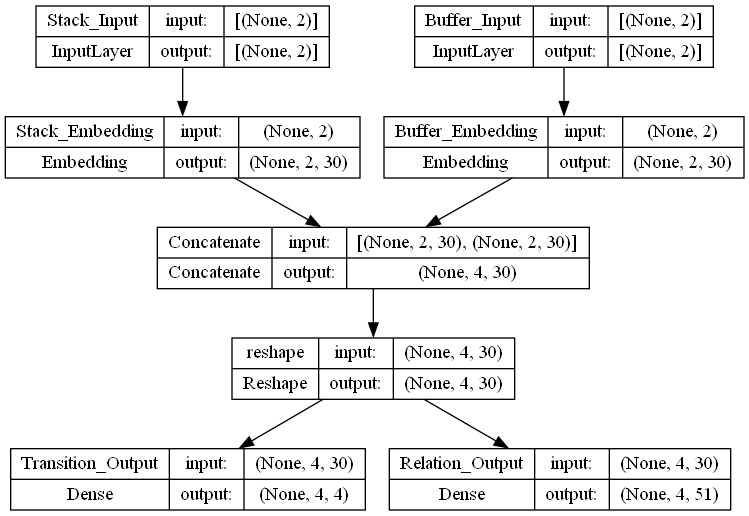

In [44]:
tf.keras.utils.plot_model(my_parser, show_shapes=True, show_layer_names=True)

In [45]:
my_parser.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
# my_parser.fit(x=[stack_inputs,buffer_inputs],y=[transition_outputs,relation_outputs],epochs=10)

In [47]:
top_s = ['EMPTY', 'is', 'highly']
tokenizer.texts_to_sequences(top_s)

[[1], [11], [278]]

# Training data

In [48]:
def parse_train(sentence,input):
    state = create_initial_state(sentence) 
    stack_inputs=[]
    buffer_inputs=[]
    actions_t=[]
    relations_t=[]
    
    while not is_final_state(state):
        relation_aux = False
        t=oracle(state,sentence)
        if len(state[0]) < 2:
            top_stack = ['EMPTY', state[0][-1]]
            top_s = ['EMPTY', input[state[0][-1]][0]]
        else:
            top_stack = [state[0][-2], state[0][-1]]
            top_s = [input[state[0][-2]][0], input[state[0][-1]][0]]
        if len(state[1]) < 2:
            top_buffer = [state[1][0], 'EMPTY']
            top_b=[input[state[1][0]][0], 'EMPTY']
        else:
            top_buffer = [state[1][0], state[1][1]]
            top_b=[input[state[1][0]][0], input[state[1][1]][0]]
            
        if t=="LA":
            relation_aux = True
            state=apply_LA(state,sentence)
        elif t=="RA":
            relation_aux = True
            state=apply_RA(state,sentence)
        elif t=="REDUCE":
            state=apply_REDUCE(state)
        else:
            state=apply_SHIFT(state)
            
        if relation_aux:
            relation = state[2][-1][1]
        else:
            relation = 'None'
            
        stack_inputs.append(top_s)
        buffer_inputs.append(top_b)
        actions_t.append(t)
        relations_t.append(relation)
    
    return stack_inputs, buffer_inputs, actions_t, relations_t

In [49]:
stack_inputs, buffer_inputs, actions_t, relations_t=parse_train(oracle_[2],inputs_[2])
print(stack_inputs)
print()
print(buffer_inputs)
print()
print(actions_t)
print()
print(relations_t)

[['EMPTY', 'ROOT'], ['ROOT', 'But'], ['But', 'in'], ['in', 'my'], ['But', 'in'], ['ROOT', 'But'], ['But', 'view'], ['view', 'it'], ['it', 'is'], ['is', 'highly'], ['it', 'is'], ['view', 'it'], ['But', 'view'], ['ROOT', 'But'], ['EMPTY', 'ROOT'], ['ROOT', 'significant']]

[['But', 'in'], ['in', 'my'], ['my', 'view'], ['view', 'it'], ['view', 'it'], ['view', 'it'], ['it', 'is'], ['is', 'highly'], ['highly', 'significant'], ['significant', '.'], ['significant', '.'], ['significant', '.'], ['significant', '.'], ['significant', '.'], ['significant', '.'], ['.', 'EMPTY']]

['SHIFT', 'SHIFT', 'SHIFT', 'LA', 'LA', 'SHIFT', 'SHIFT', 'SHIFT', 'SHIFT', 'LA', 'LA', 'LA', 'LA', 'LA', 'RA', 'RA']

['None', 'None', 'None', 'nmod:poss', 'case', 'None', 'None', 'None', 'None', 'advmod', 'cop', 'nsubj', 'obl', 'cc', 'root', 'punct']


In [50]:
# Parse storing info for training

def parse(sentence):
	# sentence ["word id", "head id", "dependency label"]
	state = create_initial_state(sentence) 
	train_input = []
	train_output = []

	#		stack					buffer				action		relation
	# [s[0][-2], s[0][-1]],		[s[1][0], s[1][1]],		t,			s[2][-1][1],       

	# hay que pasar las relaciones a numero

	# if len(s[0]) < 2:
	#	['EMPTY', s[0][-1]]
	# if len(s[1]) < 2:
	#	[s[1][0], 'EMPTY']  ?
    
	while not is_final_state(state):
        
		# Only add the relation when its Left or Right arc
		relation_aux = False

		t=oracle(state,sentence)

		if len(state[0]) < 2:
			top_stack = ['EMPTY', state[0][-1]]
		else:
			top_stack = [state[0][-2], state[0][-1]]

		if len(state[1]) < 2:
			top_buffer = [state[1][0], 'EMPTY']
		else:
			top_buffer = [state[1][0], state[1][1]]

		# Left Arc
		if t=="LA":
			relation_aux = True
			state=apply_LA(state,sentence)
		# Right arc
		elif t=="RA":
			relation_aux = True
			state=apply_RA(state,sentence)
		#Reduce
		elif t=="REDUCE":
			state=apply_REDUCE(state)
		#SHIFT
		else:
			state=apply_SHIFT(state)

		if relation_aux:
			relation = state[2][-1][1]
		else:
			relation = None
		train_input.append([top_stack, top_buffer])
		train_output.append([t, relation])
		
	return state, train_input, train_output

In [51]:
sentence=oracle_[2]
final_state, train_input, train_output = parse(sentence)

In [52]:
print(train_input)
print()
print(train_output)

[[['EMPTY', 0], [1, 2]], [[0, 1], [2, 3]], [[1, 2], [3, 4]], [[2, 3], [4, 5]], [[1, 2], [4, 5]], [[0, 1], [4, 5]], [[1, 4], [5, 6]], [[4, 5], [6, 7]], [[5, 6], [7, 8]], [[6, 7], [8, 9]], [[5, 6], [8, 9]], [[4, 5], [8, 9]], [[1, 4], [8, 9]], [[0, 1], [8, 9]], [['EMPTY', 0], [8, 9]], [[0, 8], [9, 'EMPTY']]]

[['SHIFT', None], ['SHIFT', None], ['SHIFT', None], ['LA', 'nmod:poss'], ['LA', 'case'], ['SHIFT', None], ['SHIFT', None], ['SHIFT', None], ['SHIFT', None], ['LA', 'advmod'], ['LA', 'cop'], ['LA', 'nsubj'], ['LA', 'obl'], ['LA', 'cc'], ['RA', 'root'], ['RA', 'punct']]


In [53]:
training_inputs = []
training_outputs = []

for sentence in oracle_:
    final_state, train_input, train_output = parse(sentence)
    training_inputs.append(train_input)
    training_outputs.append(train_output)

In [54]:
stack_inputs = []
buffer_inputs = []
action_outputs = []
relation_outputs = []

for idx in range(len(oracle_)):
    stack_input, buffer_input, actions_t, relations_t=parse_train(oracle_[idx],inputs_[idx])

    stack_inputs.append(tokenizer.texts_to_sequences(stack_input))
    buffer_inputs.append(tokenizer.texts_to_sequences(buffer_input))
    action_outputs.append([action_dic.get(t) for t in actions_t])
    relation_outputs.append(encoderDEPREL.transform(relations_t))
    
###############################################################################################

val_stack_inputs = []
val_buffer_inputs = []
val_action_outputs = []
val_relation_outputs = []

for idx in range(len(validation_oracle_)):
    stack_input, buffer_input, actions_t, relations_t=parse_train(validation_oracle_[idx],validation_inputs_[idx])

    val_stack_inputs.append(tokenizer.texts_to_sequences(stack_input))
    val_buffer_inputs.append(tokenizer.texts_to_sequences(buffer_input))
    val_action_outputs.append([action_dic.get(t) for t in actions_t])
    val_relation_outputs.append(encoderDEPREL.transform(relations_t))

In [55]:
words_stack=[]
for i in stack_inputs:
    for j in i:
        words_stack.append(j)
        
words_buffer=[]
for i in buffer_inputs:
    for j in i:
        words_buffer.append(j)
        
actions_out=[]
for i in action_outputs:
    for j in i:
        actions_out.append(j)
        
relations_out=[]
for i in relation_outputs:
    for j in i:
        relations_out.append(j)
        
#############################################

val_words_stack=[]
for i in val_stack_inputs:
    for j in i:
        val_words_stack.append(j)
        
val_words_buffer=[]
for i in val_buffer_inputs:
    for j in i:
        val_words_buffer.append(j)
        
val_actions_out=[]
for i in val_action_outputs:
    for j in i:
        val_actions_out.append(j)
        
val_relations_out=[]
for i in val_relation_outputs:
    for j in i:
        val_relations_out.append(j)

In [74]:
buffer_inputs[0]

[[297, 70],
 [70, 2356],
 [2356, 18],
 [2356, 18],
 [18, 8],
 [8, 2357],
 [2357, 2358],
 [2358, 28],
 [2358, 28],
 [2358, 28],
 [2358, 28],
 [28, 25],
 [28, 25],
 [25, 1348],
 [1348, 188],
 [1348, 188],
 [1348, 188],
 [1348, 188],
 [1348, 188],
 [188, 1349],
 [1349, 17],
 [1349, 17],
 [17, 219],
 [17, 219],
 [219, 7],
 [219, 7],
 [7, 255],
 [255, 3],
 [255, 3],
 [3, 277],
 [3, 277],
 [3, 277],
 [277, 1],
 [277, 1]]

In [56]:
targets_padded = tf.keras.preprocessing.sequence.pad_sequences(action_outputs, maxlen=128, padding="post")  
action_ids= tf.keras.utils.to_categorical(targets_padded, 4) 

####################################################

val_targets_padded = tf.keras.preprocessing.sequence.pad_sequences(val_action_outputs, maxlen=128, padding="post")  
val_action_ids= tf.keras.utils.to_categorical(val_targets_padded, 4)

In [57]:
targets_padded = tf.keras.preprocessing.sequence.pad_sequences(relation_outputs, maxlen=128, padding="post")  
relation_ids= tf.keras.utils.to_categorical(targets_padded, len(encoderDEPREL.classes_))

#####################################################################

val_targets_padded = tf.keras.preprocessing.sequence.pad_sequences(val_relation_outputs, maxlen=128, padding="post")  
val_relation_ids= tf.keras.utils.to_categorical(val_targets_padded, len(encoderDEPREL.classes_))

In [58]:
stack_ids = tf.keras.preprocessing.sequence.pad_sequences(stack_inputs, maxlen=128, padding="post") 
buffer_ids = tf.keras.preprocessing.sequence.pad_sequences(buffer_inputs, maxlen=128, padding="post") 

#####################################################################################################

val_stack_ids = tf.keras.preprocessing.sequence.pad_sequences(val_stack_inputs, maxlen=128, padding="post") 
val_buffer_ids = tf.keras.preprocessing.sequence.pad_sequences(val_buffer_inputs, maxlen=128, padding="post") 

In [59]:
n=2
num_features=1

In [60]:
model=Sequential()
stack_input=tf.keras.layers.Input(shape=(128,n),name='Stack_Input')
buffer_input=tf.keras.layers.Input(shape=(128,n),name='Buffer_Input')

stack_emb=tf.keras.layers.Embedding(len(tokenizer.word_index)+1, emb_dim, mask_zero=True, name='Stack_Embedding')(stack_input)
buffer_emb=tf.keras.layers.Embedding(len(tokenizer.word_index)+1, emb_dim, mask_zero=True, name='Buffer_Embedding')(buffer_input)

x=tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(emb_dim,return_sequences=False))(stack_emb)
y=tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(emb_dim,return_sequences=False,))(buffer_emb)
concatenated_embeddings= tf.keras.layers.Concatenate(name='Concatenate')([x, y])

# features=tf.keras.layers.Reshape((2*n,emb_dim))(concatenated_embeddings)

relation_output = tf.keras.layers.Dense(len(encoderDEPREL.classes_), activation='softmax', name='Relation_Output')(concatenated_embeddings) # 50 relations (nmod:poss, case, advmod, etc.
transition_output = tf.keras.layers.Dense(len(action_dic), activation='softmax', name='Transition_Output')(concatenated_embeddings) # 4 actions (LA, RA, SHIFT, REDUCE)

my_parser=keras.Model(inputs = [stack_input, buffer_input], outputs = [transition_output, relation_output])

my_parser.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Stack_Input (InputLayer)       [(None, 128, 2)]     0           []                               
                                                                                                  
 Buffer_Input (InputLayer)      [(None, 128, 2)]     0           []                               
                                                                                                  
 Stack_Embedding (Embedding)    (None, 128, 2, 30)   192240      ['Stack_Input[0][0]']            
                                                                                                  
 Buffer_Embedding (Embedding)   (None, 128, 2, 30)   192240      ['Buffer_Input[0][0]']           
                                                                                            

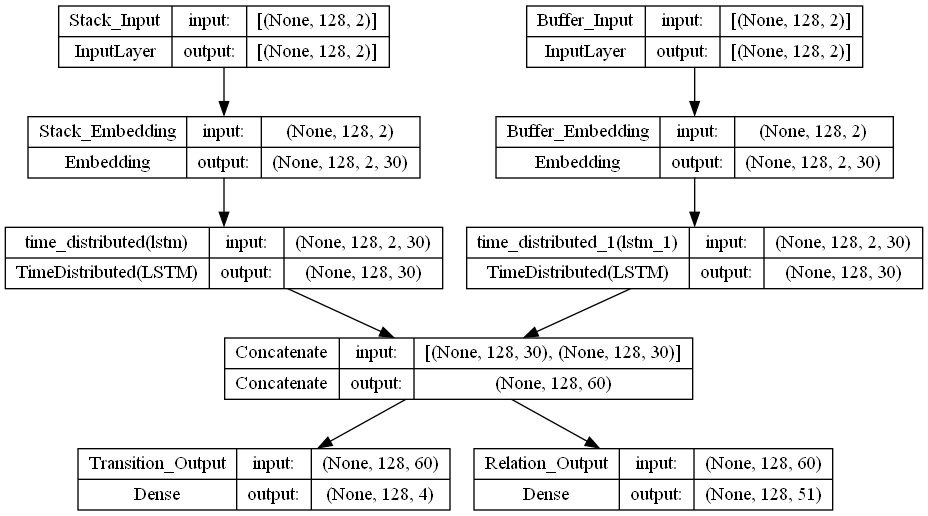

In [61]:
tf.keras.utils.plot_model(my_parser, show_shapes=True, show_layer_names=True)

In [62]:
action_ids.shape

(4775, 128, 4)

In [63]:
my_parser.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
print(val_stack_ids.shape)
print(val_buffer_ids.shape)
print(val_action_ids.shape)
print(val_relation_ids.shape)

(1068, 128, 2)
(1068, 128, 2)
(1068, 128, 4)
(1068, 128, 51)


In [65]:
my_parser.fit(x=[stack_ids, buffer_ids],y=[action_ids, relation_ids],validation_data=([val_stack_ids,val_buffer_ids],[val_action_ids, val_relation_ids]),epochs=10)
# my_parser.fit(x=[stack_ids, buffer_ids],y=[action_ids, relation_ids],epochs=10)

Epoch 1/10
150/150 [==============================] - 17s 65ms/step - loss: 4.1058 - Transition_Output_loss: 1.1538 - Relation_Output_loss: 2.9520 - Transition_Output_accuracy: 0.4643 - Relation_Output_accuracy: 0.3940 - val_loss: 3.4022 - val_Transition_Output_loss: 1.1464 - val_Relation_Output_loss: 2.2558 - val_Transition_Output_accuracy: 0.5866 - val_Relation_Output_accuracy: 0.4304
Epoch 2/10
150/150 [==============================] - 8s 53ms/step - loss: 2.3958 - Transition_Output_loss: 0.6176 - Relation_Output_loss: 1.7781 - Transition_Output_accuracy: 0.7767 - Relation_Output_accuracy: 0.5474 - val_loss: 3.1423 - val_Transition_Output_loss: 1.1494 - val_Relation_Output_loss: 1.9929 - val_Transition_Output_accuracy: 0.6646 - val_Relation_Output_accuracy: 0.5040
Epoch 3/10
150/150 [==============================] - 8s 52ms/step - loss: 1.7574 - Transition_Output_loss: 0.3811 - Relation_Output_loss: 1.3763 - Transition_Output_accuracy: 0.8624 - Relation_Output_accuracy: 0.6390 - v

In [66]:
actions_ids2= tf.keras.utils.to_categorical(actions_out, 4) 
relations_ids2= tf.keras.utils.to_categorical(relations_out, len(encoderDEPREL.classes_))
words_stack2=np.asarray(words_stack)
words_buffer2=np.asarray(words_buffer)

#############################################################################################

val_actions_ids2= tf.keras.utils.to_categorical(val_actions_out, 4) 
val_relations_ids2= tf.keras.utils.to_categorical(val_relations_out, len(encoderDEPREL.classes_))
val_words_stack2=np.asarray(val_words_stack)
val_words_buffer2=np.asarray(val_words_buffer)


In [67]:
n=2 
emb_dim=30

model=Sequential()
stack_input=tf.keras.layers.Input(shape=(n,),name='Stack_Input')
buffer_input=tf.keras.layers.Input(shape=(n,),name='Buffer_Input')

stack_emb=tf.keras.layers.Embedding(len(tokenizer.word_index)+1, emb_dim, mask_zero=True, name='Stack_Embedding')(stack_input)
buffer_emb=tf.keras.layers.Embedding(len(tokenizer.word_index)+1, emb_dim, mask_zero=True, name='Buffer_Embedding')(buffer_input)

x=tf.keras.layers.LSTM(emb_dim,return_sequences=False, name='LSTM_Stack')(stack_emb)
y=tf.keras.layers.LSTM(emb_dim,return_sequences=False,name='LSTM_Buffer')(buffer_emb)
concatenated_embeddings= tf.keras.layers.Concatenate(name='Concatenate')([x, y])

relation_output = tf.keras.layers.Dense(len(encoderDEPREL.classes_), activation='softmax', name='Relation_Output')(concatenated_embeddings) # 50 relations (nmod:poss, case, advmod, etc.
transition_output = tf.keras.layers.Dense(len(action_dic), activation='softmax', name='Transition_Output')(concatenated_embeddings) # 4 actions (LA, RA, SHIFT, REDUCE)

my_parser=keras.Model(inputs = [stack_input, buffer_input], outputs = [transition_output, relation_output])

my_parser.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Stack_Input (InputLayer)       [(None, 2)]          0           []                               
                                                                                                  
 Buffer_Input (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 Stack_Embedding (Embedding)    (None, 2, 30)        192240      ['Stack_Input[0][0]']            
                                                                                                  
 Buffer_Embedding (Embedding)   (None, 2, 30)        192240      ['Buffer_Input[0][0]']           
                                                                                            

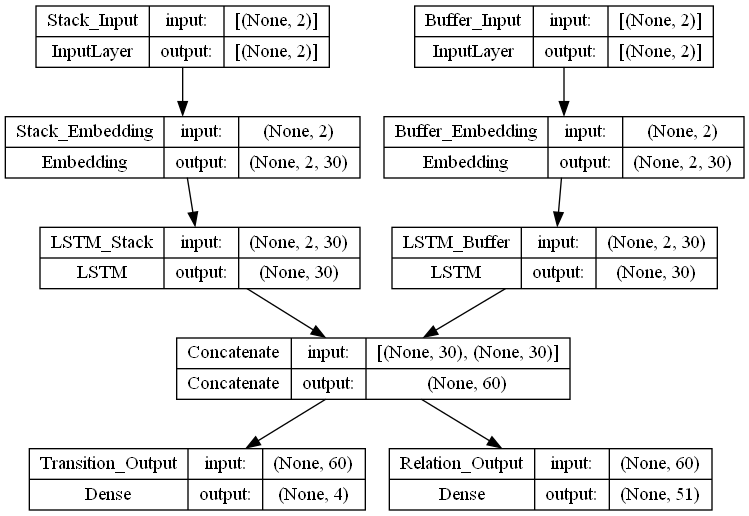

In [68]:
tf.keras.utils.plot_model(my_parser, show_shapes=True, show_layer_names=True)

In [69]:
my_parser.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
my_parser.fit(x=[words_stack2, words_buffer2],y=[actions_ids2, relations_ids2],validation_data=([val_words_stack2,val_words_buffer2],[val_actions_ids2, val_relations_ids2]),epochs=10)
# my_parser.fit(x=[words_stack2, words_buffer2],y=[actions_ids2, relations_ids2],epochs=10)

Epoch 1/10
1438/1438 [==============================] - 17s 8ms/step - loss: 2.2966 - Transition_Output_loss: 0.6060 - Relation_Output_loss: 1.6906 - Transition_Output_accuracy: 0.7496 - Relation_Output_accuracy: 0.5747 - val_loss: 3.0431 - val_Transition_Output_loss: 1.1896 - val_Relation_Output_loss: 1.8535 - val_Transition_Output_accuracy: 0.6825 - val_Relation_Output_accuracy: 0.5659
Epoch 2/10
1438/1438 [==============================] - 9s 6ms/step - loss: 1.1848 - Transition_Output_loss: 0.2792 - Relation_Output_loss: 0.9056 - Transition_Output_accuracy: 0.9008 - Relation_Output_accuracy: 0.7560 - val_loss: 3.0993 - val_Transition_Output_loss: 1.2597 - val_Relation_Output_loss: 1.8395 - val_Transition_Output_accuracy: 0.6869 - val_Relation_Output_accuracy: 0.6123
Epoch 3/10
1438/1438 [==============================] - 9s 6ms/step - loss: 0.8487 - Transition_Output_loss: 0.2039 - Relation_Output_loss: 0.6448 - Transition_Output_accuracy: 0.9290 - Relation_Output_accuracy: 0.8223 

In [71]:
x=my_parser.predict([words_stack2[8:9], words_buffer2[8:9]])
# index of the maximun value for array x[0] and x[1] 
action_predicted=list(action_dic.keys())[list(action_dic.values()).index(np.argmax(x[0]))]
relation_predicted=encoderDEPREL.inverse_transform([np.argmax(x[1])])[0]

action_predicted,relation_predicted

1/1 [==============================] - 2s 2s/step


('LA', 'det')